# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [18]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

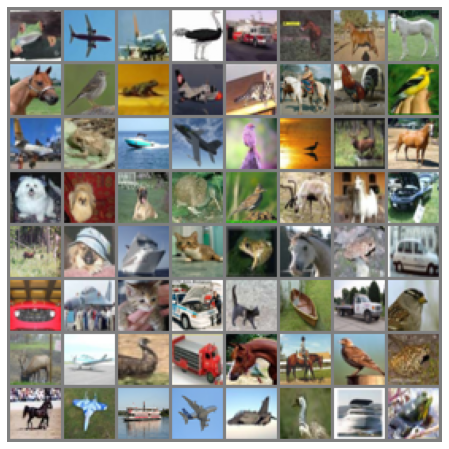

In [20]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [21]:
def output_size(h_in=1, kernel=1, stride=1):
      h_out = (h_in - kernel + 1)/stride
      return int(h_out)

In [22]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
      if self.first:
          print(f"Size: {x.size()}")
          self.first = False
      return x


class Model(nn.Module):

    def __init__(self, numChannels, size_img, out_channels, out_channel2, k, kernel, num_classes):
      super().__init__()
      self.num_classes = num_classes
      self.activation = torch.nn.ReLU()
      self.conv1 = torch.nn.Conv2d(in_channels=numChannels, out_channels=out_channels, kernel_size=kernel)
      self.maxpool1 = torch.nn.MaxPool2d(kernel_size=k)
      self.size1 = output_size(h_in = size_img, kernel=kernel, stride = k)
      self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channel2, kernel_size=kernel)
      self.maxpool2 = torch.nn.MaxPool2d(kernel_size=k)
      self.size2 = output_size(h_in=self.size1, kernel=kernel, stride=k)
      n_features = (self.size2)**2*out_channel2
      self.net = nn.Sequential(
          nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
          nn.Linear(int(n_features), 512),
          torch.nn.ReLU(nn.BatchNorm1d(512)),
          nn.Linear(512, 128),
          torch.nn.Dropout(0.7),
          torch.nn.ReLU(),
          nn.Linear(128, num_classes))
      self.dropout = torch.nn.Dropout(0.7)
      #softmax
      self.logSoftmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
      #print(x.size())
      x = self.conv1(x)
      x = self.activation(x)
      x = self.maxpool1(x)
      x = self.dropout(x)
      x = self.conv2(x)
      x = self.dropout(x)
      x = self.activation(x)
      x = self.maxpool2(x)
      x = self.net(x)
      #x = self.logSoftmax(x)
      return x


size_img = 32
out_channels = 512 #256
kernel = 5
out_channel2 = 256 #128
k = 2
numChannels = 3
model = Model(numChannels, size_img, out_channels, out_channel2, k, kernel, n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
#print(model)

Model(
  (activation): ReLU()
  (conv1): Conv2d(3, 512, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=512, bias=True)
    (2): ReLU(
      inplace=True
      (inplace): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): Dropout(p=0.7, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (logSoftmax): Softmax(dim=1)
)

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=5e-4)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [24]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.2728909  -0.19642618 -0.23338474 -0.24838322  0.09379937  0.06010289
   0.2855124   0.06149838  0.20789815 -0.04478795]
 [ 0.399861    0.359628   -0.2728389  -0.21755561  0.13820726  0.04578905
   0.2852838  -0.12165536  0.4336457  -0.43000287]]
Output probabilities:
[[0.07691602 0.08302809 0.0800155  0.07882433 0.11098605 0.10730851
  0.13443993 0.10745837 0.12440014 0.09662303]
 [0.1344508  0.12914878 0.06861412 0.07251414 0.10349718 0.09436084
  0.11989556 0.07981263 0.13907076 0.05863515]]


In [25]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

from tqdm import tqdm
        
for epoch in tqdm(range(num_epochs)):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
###############################################################################
            
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
###############################################################################        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             val accuracy: {valid_accuracies[-1]}")

print("Finished training.")

  0%|          | 0/20 [00:00<?, ?it/s]

Step 500     training accuracy: 0.29634375
             val accuracy: 0.4569


  5%|▌         | 1/20 [00:39<12:23, 39.14s/it]

Step 1000    training accuracy: 0.45885894495412843
             val accuracy: 0.5378
Step 1500    training accuracy: 0.494
             val accuracy: 0.5832


 10%|█         | 2/20 [01:17<11:31, 38.43s/it]

Step 2000    training accuracy: 0.5385607798165137
             val accuracy: 0.6054


 15%|█▌        | 3/20 [01:51<10:23, 36.66s/it]

Step 2500    training accuracy: 0.5777191558441559
             val accuracy: 0.6198
Step 3000    training accuracy: 0.5971875
             val accuracy: 0.6419


 20%|██        | 4/20 [02:29<09:54, 37.15s/it]

Step 3500    training accuracy: 0.618195564516129
             val accuracy: 0.6512


 25%|██▌       | 5/20 [03:04<09:02, 36.19s/it]

Step 4000    training accuracy: 0.6491319444444444
             val accuracy: 0.6682
Step 4500    training accuracy: 0.65084375
             val accuracy: 0.6954


 30%|███       | 6/20 [03:42<08:35, 36.84s/it]

Step 5000    training accuracy: 0.6790787337662337
             val accuracy: 0.698


 35%|███▌      | 7/20 [04:16<07:49, 36.13s/it]

Step 5500    training accuracy: 0.7115384615384616
             val accuracy: 0.7027
Step 6000    training accuracy: 0.69040625
             val accuracy: 0.7116


 40%|████      | 8/20 [04:54<07:20, 36.71s/it]

Step 6500    training accuracy: 0.7107453893442623
             val accuracy: 0.725
Step 7000    training accuracy: 0.71365625
             val accuracy: 0.7304


 45%|████▌     | 9/20 [05:32<06:48, 37.13s/it]

Step 7500    training accuracy: 0.7283549783549783
             val accuracy: 0.7359


 50%|█████     | 10/20 [06:07<06:03, 36.33s/it]

Step 8000    training accuracy: 0.7470486111111111
             val accuracy: 0.7496
Step 8500    training accuracy: 0.74390625
             val accuracy: 0.7469


 55%|█████▌    | 11/20 [06:45<05:31, 36.81s/it]

Step 9000    training accuracy: 0.7542792085427136
             val accuracy: 0.7409


 60%|██████    | 12/20 [07:19<04:48, 36.12s/it]

Step 9500    training accuracy: 0.7649515086206896
             val accuracy: 0.7526
Step 10000   training accuracy: 0.764375
             val accuracy: 0.7531


 65%|██████▌   | 13/20 [07:57<04:16, 36.70s/it]

Step 10500   training accuracy: 0.7803611526946108
             val accuracy: 0.7576


 70%|███████   | 14/20 [08:32<03:36, 36.05s/it]

Step 11000   training accuracy: 0.7947716346153846
             val accuracy: 0.7699
Step 11500   training accuracy: 0.7888125
             val accuracy: 0.7639


 75%|███████▌  | 15/20 [09:10<03:03, 36.72s/it]

Step 12000   training accuracy: 0.8016782407407408
             val accuracy: 0.7689
Step 12500   training accuracy: 0.796125
             val accuracy: 0.7694


 80%|████████  | 16/20 [09:48<02:28, 37.13s/it]

Step 13000   training accuracy: 0.8100345799180327
             val accuracy: 0.7697


 85%|████████▌ | 17/20 [10:23<01:49, 36.41s/it]

Step 13500   training accuracy: 0.8165958737864077
             val accuracy: 0.7676
Step 14000   training accuracy: 0.8159375
             val accuracy: 0.7708


 90%|█████████ | 18/20 [11:01<01:13, 36.87s/it]

Step 14500   training accuracy: 0.8301518278301887
             val accuracy: 0.7767


 95%|█████████▌| 19/20 [11:35<00:36, 36.19s/it]

Step 15000   training accuracy: 0.8359375
             val accuracy: 0.7737
Step 15500   training accuracy: 0.83359375
             val accuracy: 0.777


100%|██████████| 20/20 [12:13<00:00, 36.70s/it]

Finished training.


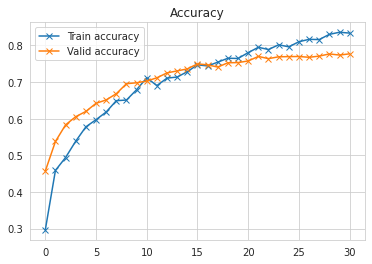

 
Training accuracy 83.59
Validation accuracy 77.7


In [26]:
plt.plot(train_accuracies, marker='x', label='Train accuracy')
plt.plot(valid_accuracies, marker='x', label='Valid accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
print(' ')
print(f"Training accuracy {max(train_accuracies)*100:.2f}") #
print('Validation accuracy', max(valid_accuracies)*100) #77.28 76.99

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

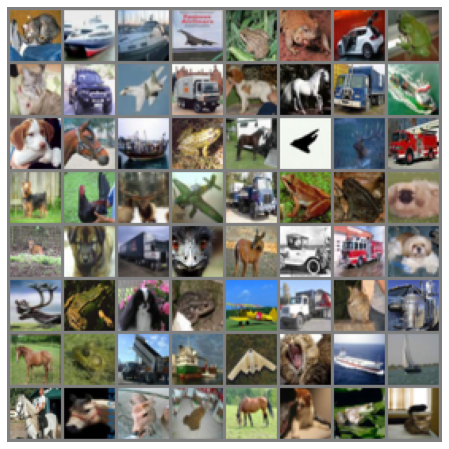

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         truck    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          truck    
    deer          deer     
  airplane        deer     
    truck         truck    
    frog          frog     
    frog           cat     
     dog           dog     
    deer          bird     
     dog           c

In [27]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [28]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [29]:
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.7794


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


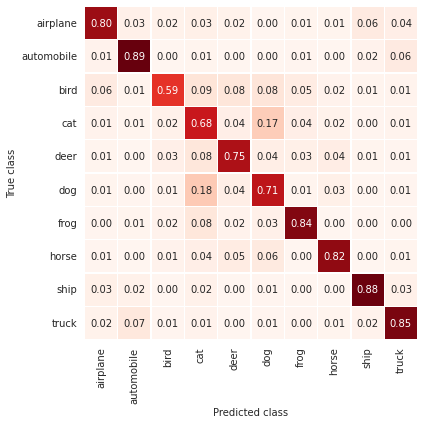

In [30]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

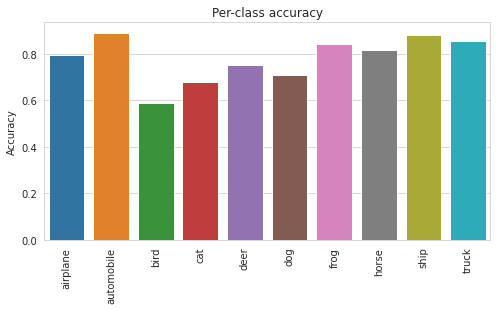

In [31]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

1. Running my convolutional neural net for 20 epochs gives me a test accuracy of 77.94% and for what concerns the training and validation accuracy I got 83.59% and 77.70%, respectively. Therefore, we can say the model works fine and I maneged to avoid overfitting in the training set eventually.

2. I tried different models. At first, I built a simple convolutional net with one conv layer, one maxpool and one flatten linear layer. Number of output channels 15 and running for only 2 epochs. I got at that point a test accuracy of around 58%. After this first trial, I added one more convolutional layer and one maxpool and then I played around with the number of output channels each conv layer and the optimizer parameters. The best result got so far was 66.50% of test accuracy. To get increase the perfomance I decided to add a batchnorm and a dropout(0.7) to avoid overfitting. Finilly I run for 20 epochs and increased the output channels and I got the results described in the 1st ansewr.\
The changes that boost the most my model were definatelly the increased number of output channels.

3. The key lesson I got in this exercise is the importance of choosing the right size of the convolutional layer, because thanks to it we look for the common pattern in the image. Thus, if the patter we're looking is too small we would search for too long and end up having a big quantity of pattern to compare. Conversely, if it is too big we won't have enough information to detect the images.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [32]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**\
**Exercise 7 chapter 1**\
"Write out Equation (22) in component form, and verify that it gives the same result as the rule (4) for computing the output of a sigmoid neuron."

Equation (22) has the form: $a' = σ(wa + b)$, whereas equation (4) is defined as: $\frac{1}{1 + \exp(- \sum_jw_j*x_j - b)}$.\
From equation (3) in the book we also now that: $σ(z) = \frac{1}{1 + e^{-z}}$. Therefore, keeping that in mind we can rewrite equation (22) as $a' = \frac{1}{1 + exp(- \sum_j w_j*a_j - b)}$.\
Where, $w$ is a matrix of the weights and $a$ is a vector listing the activations of the second layer of neurons. 

